In [2]:
import operator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

In [4]:
liverdata = pd.read_csv('C:\\projects\\liverdata\\indian_liver_patient.csv')
liverdata['Gender'] = liverdata['Gender'].replace({'Male': 1, 'Female': 0})
liverdata.head()

C:\Users\prade\AppData\Local\Temp\ipykernel_5052\1474658112.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  liverdata['Gender'] = liverdata['Gender'].replace({'Male': 1, 'Female': 0})


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [6]:
liverdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    int64  
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(6)
memory usage: 50.2 KB


In [8]:
liverdata.groupby('Dataset').size()

Dataset
1    416
2    167
dtype: int64

In [10]:
liverdata.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

<h2>Step 2: Feature Engineering </h2>

In [13]:
feature_names = liverdata.columns[:10]
feature_names

Index(['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
       'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin',
       'Albumin_and_Globulin_Ratio'],
      dtype='object')

In [15]:
X = liverdata[feature_names]
Y = liverdata.Dataset

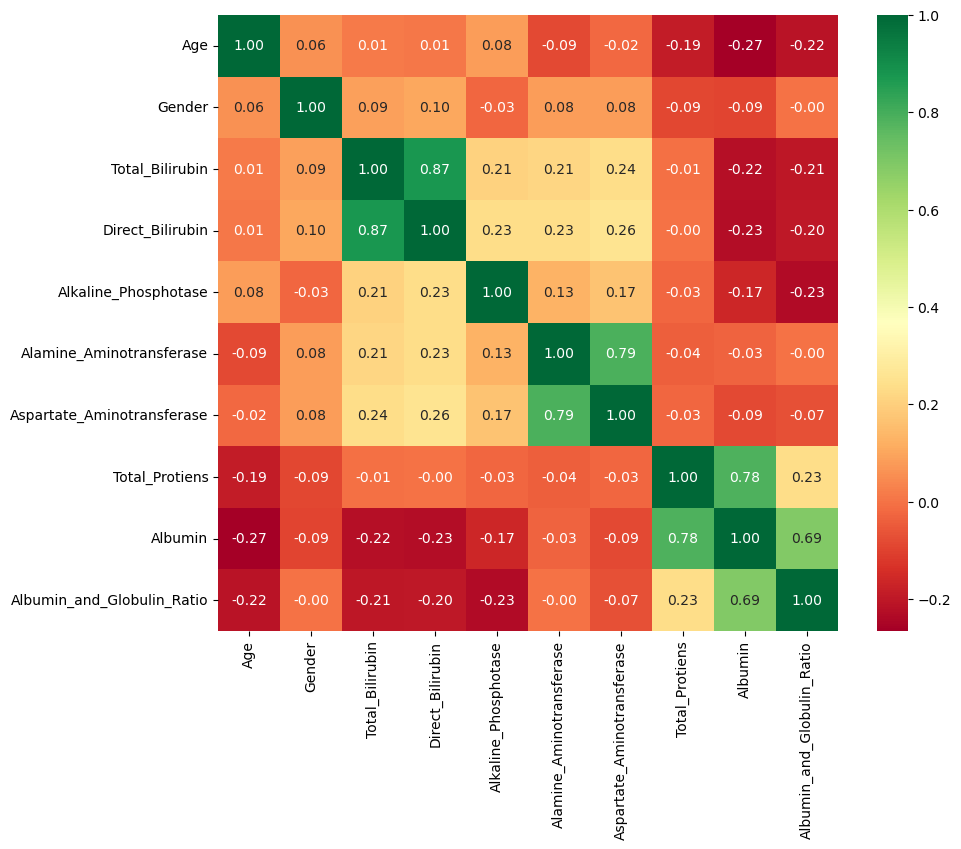

In [17]:
sns.heatmap(
    data=X.corr(),
    annot=True,
    fmt='.2f',
    cmap='RdYlGn'
)

fig = plt.gcf()
fig.set_size_inches(10, 8)

plt.show()

In [19]:
# I temporarily removed a few Glucose, BloodPressure and BMI rows with 0 values for better RFE result
liverdata_mod = liverdata.dropna()
liverdata_mod.shape

(579, 11)

C:\Users\prade\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\prade\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

rfecv.grid_scores_: [0.71503327 0.71330913 0.70983061 0.70638234 0.70638234 0.7184513
 0.72192982 0.73055051 0.72707199 0.70986086]


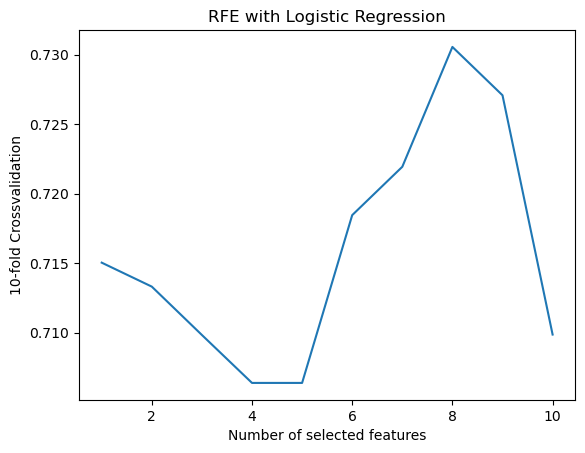

rfecv.support_: [ True  True False  True False  True  True  True  True  True]

The most suitable features for prediction: ['Age', 'Gender', 'Direct_Bilirubin', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio']


In [42]:
X_mod = liverdata_mod[feature_names]
y_mod = liverdata_mod.Dataset

strat_k_fold = StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=42
)

logreg_model = LogisticRegression()

rfecv = RFECV(
    estimator=logreg_model,
    step=1,
    cv=strat_k_fold,
    scoring='accuracy'
)
rfecv.fit(X_mod, y_mod)

plt.figure()
plt.title('RFE with Logistic Regression')
plt.xlabel('Number of selected features')
plt.ylabel('10-fold Crossvalidation')

# grid_scores_ returns a list of accuracy scores
# for each of the features selected
# Replace rfecv.grid_scores_ with rfecv.cv_results_['mean_test_score']
# Replace rfecv.grid_scores_ with rfecv.cv_results_['mean_test_score']
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])

print('rfecv.grid_scores_: {grid_scores}'.format(grid_scores=rfecv.cv_results_['mean_test_score']))

plt.show()

# support_ is another attribute to find out the features
# which contribute the most to predicting
new_features = list(filter(
    lambda x: x[1],
    zip(feature_names, rfecv.support_)
))

print('rfecv.support_: {support}'.format(support=rfecv.support_))

# Features are the most suitable for predicting the response class
new_features = list(map(operator.itemgetter(0), new_features))
print('\nThe most suitable features for prediction: {new_features}'.format(new_features=new_features))

<h2> Step 3: Data standardization </h2>

<h4>Standardize features by removing the mean and scaling to unit variance.</h4>

In [45]:
# Features chosen based on RFECV result
best_features = ['Age', 'Gender', 'Direct_Bilirubin','Alkaline_Phosphotase', 'Alamine_Aminotransferase',  
                 'Total_Protiens','Albumin_and_Globulin_Ratio']

X_mod = StandardScaler().fit_transform(X_mod[best_features])

In [47]:
# Split your data into training and testing (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_mod,
    y_mod,
    random_state=42,
    test_size=0.20
)

Principal component analysis (PCA)¶
The main goal of a PCA analysis is to identify patterns in data. PCA aims to detect the correlation between variables. If a strong correlation between variables exists, the attempt to reduce the dimensionality only makes sense.

In [50]:
pca = PCA(n_components=2)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print(pca.explained_variance_ratio_)
print('PCA sum: {:.2f}%'.format(sum(pca.explained_variance_ratio_) * 100))

[0.22659252 0.18682196]
PCA sum: 41.34%


In [52]:
from sklearn.model_selection import GridSearchCV

c_values = list(np.arange(1, 100))

param_grid = [
    {
        'C': c_values,
        'penalty': ['l1'],
        'solver': ['liblinear'],
        'multi_class': ['ovr'],
        'random_state': [42]
    },
    {
        'C': c_values,
        'penalty': ['l2'],
        'solver': ['liblinear', 'newton-cg', 'lbfgs'],
        'multi_class': ['ovr'],
        'random_state': [42]
    }
]

grid = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=strat_k_fold,
    scoring='f1'
)
grid.fit(X_mod, y_mod)

# Best LogisticRegression parameters
print(grid.best_params_)
# Best score for LogisticRegression with best parameters
print('Best score: {:.2f}%'.format(grid.best_score_ * 100))

{'C': 1, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}
Best score: 82.74%


In [54]:
log_reg = LogisticRegression(
    # Parameters chosen based on GridSearchCV result
    C=1,
    multi_class='ovr',
    penalty='l2',
    solver='liblinear',
    random_state=42
)
log_reg.fit(X_train, y_train)

log_reg_predict = log_reg.predict(X_test)
log_reg_predict_proba = log_reg.predict_proba(X_test)[:, 1]

In [56]:
print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, log_reg_predict) * 100))
print('AUC: {:.2f}%'.format(roc_auc_score(y_test, log_reg_predict_proba) * 100))
print('Classification report:\n\n', classification_report(y_test, log_reg_predict))
print('Training set score: {:.2f}%'.format(log_reg.score(X_train, y_train) * 100))
print('Testing set score: {:.2f}%'.format(log_reg.score(X_test, y_test) * 100))

Accuracy: 63.79%
AUC: 75.66%
Classification report:

               precision    recall  f1-score   support

           1       0.64      0.95      0.77        73
           2       0.56      0.12      0.19        43

    accuracy                           0.64       116
   macro avg       0.60      0.53      0.48       116
weighted avg       0.61      0.64      0.55       116

Training set score: 72.35%
Testing set score: 63.79%


In [58]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)
print('Confusion Matrix: \n', confusion_matrix(y_test,log_reg_predict))

(463, 2)
(463,)
(116, 2)
(116,)
Confusion Matrix: 
 [[69  4]
 [38  5]]
